Source publication for dataset: 
https://www.nature.com/articles/s41467-018-02866-0

In [7]:
import anndata as ad
import numpy as np
import pandas as pd
from copy import deepcopy
import seaborn as sn

In [3]:
n_cells = 456
n_genes = 100
PWscores = np.zeros((n_cells, n_genes, n_genes))

for i in range(n_cells):
    path = "./../data/TEsmESC/geneXgene{i}.csv".format(i=(i+1))
    df_temp = pd.read_csv(path)
    PWscores[i, :, :] = np.copy(df_temp.values)
    

TODO: <br />
Make the graph! We got cells, and we got PW gene scores for all the cells! <br />
What does a high score mean? It means that within the neighbourhood of that cell, the first gene is informative of the other gene! <br />
Each entry of the matrix: PWscores[i, j, k] represents the transfer entropy score of j → k in the neighbourhood of cell i. <br />
Why's that significant? How does that help anyone?
--> Read up on that! <br/> <br/>

Steps: <br/>
1. Get the OG data and remake the trajectory by just putting the most similar cells side-by-side <br/>
2. Do the same with the PW network and see how the two compare <br/>
(first two steps are just to get a sense of the cell manifold)<br/>
3. Find high cost PATHS in each cell, i.e. represent each cell as an interaction network and find the highest entropy paths through it <br/>
4. Use these as the edges of your hypergraph, and do this for all cells <br/>
(it makes sense because we're interested in what gene pathways have high TE scores across cells)<br/>
5. Spectral clustering hopefully reveals some developmentally critical genes<br/>
(keep in mind this is a dataset of transcription factors!)<br/> 


Initialize the path(s) with the maximum value(s) <br/>
    - decide which values to keep <i>relative</i> to the <i>original maximum</i> value

In [4]:
# Remember, the entries in the matrix are weights for edges... what you want to ultimately output are the genes involved in the edges!
# row/col index = row->col edge, i.e. entropy between gene_row->gene_col (TODO: or the reverse)
# so you wanna output the row->col indices, and eventually map those back to gene names! 

# Visualizing TE scores across cells (over time)

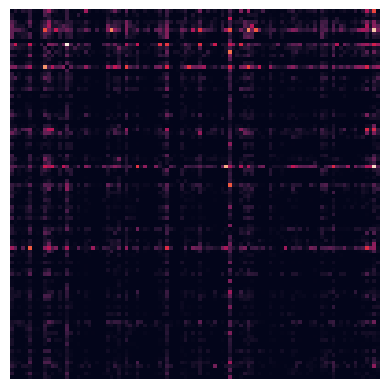

In [19]:
for i in range(n_cells):
    heat_fig = sn.heatmap(PWscores[i, :, :], xticklabels=False, yticklabels=False, cbar=False, square=True)
    as_file = heat_fig.get_figure()
    path = "./../out/cell{i}.png".format(i = i + 1)
    as_file.savefig(path, bbox_inches='tight')
    # ax.tick_params(left=False, bottom=False)

# The informative gene pathway extraction algorithm
(For now implemented as just an easy intuitive iterative solution, maybe later will attempt a numpy/C++ acceleration!)

In [4]:
# TODO: right now it is just greedy bfs, but I want paths to be able to branch and for multiple nodes to all connect to a common node
# eg. if you get 3-> 59, 18 -> 59 that outta be shown as 3&18 -> 59 (somehow)
"""
TODO: just build the incidence matrix as you go? each iteration adds a new set 'layer' of edges
--> see notes !
implement this proper (will write another function)
"""
def get_hyperedge_set(cell_index):

    cell_nw = PWscores[cell_index, :, :]
    
    # init
    paths = []
    max_itrs = n_genes
    itrs = 0
    tolerance = np.max(cell_nw) * 0.2 # all scores within whatever % of the max
    max_path_len = 0
    max_path_len_prev = -1

    for i in range(n_genes): #row is the predecessor node
        index_max = np.argmax(cell_nw[i, :]) # index of max column is the successor (incident) node
        
        if cell_nw[i, index_max] > tolerance:
            paths.append([i, index_max])

    # update
    while (max_itrs > itrs) and (max_path_len > max_path_len_prev):
        max_path_len_prev = max_path_len
        new_paths = deepcopy(paths) 
        for p in range(len(paths)):
            path = paths[p]
            if len(path) >= max_path_len:
                row = path[-1]
                index_max = np.argmax(cell_nw[row, :])
                
                if (cell_nw[row, index_max] > tolerance) and (index_max not in new_paths[p]):
                    new_paths[p].append(index_max)

        max_path_len = max( len(x) for x in new_paths )
        itrs += 1
        paths = deepcopy(new_paths)
    
    return paths

# Creation of the hypergraph

Note: a simple canonical edge has the form of tail->head

In [21]:
"""
Merges tails with common heads to identify all the multi-arity relations to represent as hedges and updates the supplied incidence matrix with these final hedges.
_edges: a list of tuples (tail_set, head_set) of all the initial single-tailed edges (note: they are sets, not lists!)
B: a list of n_gene-sized integer numpy arrays to represent the incidence matrix to update.
TODO: Test and be especially make sure Python's memory system isn't doing any weird reference copying and producing the wrong stuff!
Note, all set operations return copies, so this SHOULD be okay.
"""
def merge_edges(_edges, B):
    
    # init
    edges = deepcopy(_edges)
    m = len(edges)

    # Stop when there's only a single edge left (not possible to merge anything else)
    while (m >= 2):
        
        new_edges = [] 
        for i in range(0, m, 1):
            e1 = edges[i]
            for j in range(i + 1, m, 1):
                e2 = edges[j]
                common_heads = e1[1].intersection(e2[1])
                if (len(common_heads) > 0):
                    
                    # The new edge
                    new_tails = e1[0].union(e2[0]) 
                    new_edge = ([new_tails, common_heads])
                    new_edges.append(new_edge)

                    # Updating old edges (their head sets)
                    e1[1] = set(e1[1] - common_heads)
                    e2[1] = set(e2[1] - common_heads)

        
        # Add all edges with non-null head sets to the incidence matrix!
        for edge in edges:
            col = np.zeros(n_genes)
            if len(edge[1]) > 0:
                # TODO: handle weights... how? Each hedge gets assigned a single weight,and those get stored in a different matrix/use a function. 
                for tail in edge[0]:
                    col[tail] = -1
                for head in edge[1]:
                    col[head] = 1

                B.append(np.copy(col))
        
        edges = deepcopy(new_edges)
        m = len(edges)

In [22]:
""" 
Creates a hypergraph, represented using an incidence matrix, from the given cell's PW gene network. 
cell_index: the index into the PWscores array for the desired cell.
p: percentage parameter to use in tolerance calculation; decides which relationships relative to the maximum PW TE. 
returns: B the incidence matrix of the constructed hypergraph. 
"""
def construct_hyper_graph(cell_index, p):
    # init
    unique_genes = set()
    cell_nw = PWscores[cell_index, :, :]

    # The incidence matrix (might use different data structure)
    B = []

    # all scores within whatever % of the max
    tolerance = np.max(cell_nw) * p

    tails = set(np.arange(start=0, stop=n_genes, step=1))

    # debug var
    count = 0

    # TODO: TEST IT ALL 
    while (len(tails) > 0):
        edges = []
        new_tails = set()
        heads_to_remember = set()

        for tail in tails:
            heads = set(np.flatnonzero(cell_nw[tail, :] > tolerance))
            
            # Termination condition: once there's no new heads added this never gets hit, no new tails get added and the tail set becomes null at the end of while itr
            if (len(heads) > 0) and (heads.isdisjoint(unique_genes)):
                
                count += 1
                
                for head in heads:
                    # error handling
                    if (cell_nw[tail, head] <= tolerance):
                        print("BIG BUG") # TODO: keep this error cond here and handle it better!

                    # update the next-level tails
                    new_tails.add(head)
                    
                    # TODO: maybe make the set of all heads for this level here and wait till the end of the iteration to deep copy it over?
                    heads_to_remember.add(head)
                    
                # update the edge set for this hgraph level
                tail_as_set = set()
                tail_as_set.add(tail)
                edges.append([tail_as_set, heads])
        
        # update the unique heads set
        # for e in edges:
        #     for h in e[1]:
        #         unique_genes.add(h)
        for h in heads_to_remember:
            unique_genes.add(h)

        merge_edges(edges, B)
        tails = set(deepcopy(new_tails))
    
    return B



In [7]:
# Playing with sets
my_set = set()
my_set.add(4)
my_set.add(2)
my_set.add(4)
my_set.add(3)

b_set = set()
b_set.add(2)
b_set.add(3)

# this code works!
a_set = set(np.arange(0, 3))

l1 = list(deepcopy(a_set))
my_set = my_set - b_set
len(my_set)
a_set.intersection(b_set)
b_set = set(deepcopy(a_set))
for a in a_set:
    # print(type(int(a)))
    my_set.add(a)

null_s = set()
b_set = set(deepcopy(null_s))
my_set.isdisjoint(a_set)

False

In [32]:
# for i in range(n_cells):
#     G = construct_hyper_graph(i, 0.7)
#     for e in G:
#         # if (np.sum(e < 0)) >= 2:
#             # print("This SHOULD happen, you know from the pathway function, so either this is a bug OR the uniqueness invariant is too strong!\n")
#         if (np.sum(e < 0) == 0):
#             print("bug")
#         if (np.sum(e > 0) == 0):
#             print("a lesser bug")
#         if (np.sum(e < 0) > 1) and (np.sum(e > 0) > 1):
#             print("Number of tails: {x}".format(x=np.sum(e < 0)))
#             print("Number of heads: {x}\n".format(x=np.sum(e > 0)))

#TODO: Test proper via some contrived examples

In [9]:
# np.sum(G[2] < 0) 

# Spectrally clustering the hypergraph
(hopefully revealing the informative gene pathways)

In [10]:
# # TODO
# from sklearn.cluster import KMeans

# # our adjacency matrix
# print("Adjacency Matrix:")
# print(A)

# # Adjacency Matrix:
# # [[0. 1. 1. 0. 0. 1. 0. 0. 1. 1.]
# #  [1. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
# #  [1. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
# #  [0. 0. 0. 0. 1. 1. 0. 0. 0. 0.]
# #  [0. 0. 0. 1. 0. 1. 0. 0. 0. 0.]
# #  [1. 0. 0. 1. 1. 0. 1. 1. 0. 0.]
# #  [0. 0. 0. 0. 0. 1. 0. 1. 0. 0.]
# #  [0. 0. 0. 0. 0. 1. 1. 0. 0. 0.]
# #  [1. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
# #  [1. 0. 0. 0. 0. 0. 0. 0. 1. 0.]]

# # diagonal matrix
# D = np.diag(A.sum(axis=1))

# # graph laplacian
# L = D-A

# # eigenvalues and eigenvectors
# vals, vecs = np.linalg.eig(L)

# # sort these based on the eigenvalues
# vecs = vecs[:,np.argsort(vals)]
# vals = vals[np.argsort(vals)]

# # kmeans on first three vectors with nonzero eigenvalues
# kmeans = KMeans(n_clusters=4)
# kmeans.fit(vecs[:,1:4])
# colors = kmeans.labels_

# print("Clusters:", colors)